In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
df_cust_data = pd.read_excel('Customer_Data.xlsx')
df_plant = pd.read_excel('Plant_Master.xlsx')
df_invoice = pd.read_csv('Final_invoice.csv',error_bad_lines=False, index_col=False, dtype='unicode')

In [3]:
remove_cols = []
for column in df_invoice.columns:
    
    if ((df_invoice[column].isnull().sum()*100)/len(df_invoice)) > 10:
        remove_cols.append(column)
        

df_invoice.drop(columns=remove_cols, axis = 1,inplace=True)

df_invoice.columns = df_invoice.columns.str.replace(r'[^\w\s]', '')
df_invoice.columns = df_invoice.columns.str.replace(' ', '')

df_invoice.columns = df_invoice.columns.str.upper()

In [4]:
df_invoice.columns

Index(['UNNAMED0', 'AREALOCALITY', 'CITY', 'CUSTTYPE', 'CUSTOMERNO',
       'DISTRICT', 'GATEPASSTIME', 'INVOICEDATE', 'INVOICENO', 'INVOICETIME',
       'JOBCARDNO', 'JOBCARDDATE', 'JOBCARDTIME', 'KMSREADING', 'LABOURTOTAL',
       'MAKE', 'MISCTOTAL', 'MODEL', 'OSLTOTAL', 'ORDERTYPE', 'PARTSTOTAL',
       'PINCODE', 'PLANT', 'PLANTNAME1', 'PRINTSTATUS', 'RECOVRBLEXP',
       'REGNNO', 'TOTALAMTWTDTAX', 'USERID'],
      dtype='object')

In [5]:
df_invoice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492314 entries, 0 to 492313
Data columns (total 29 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   UNNAMED0        492314 non-null  object
 1   AREALOCALITY    468424 non-null  object
 2   CITY            492313 non-null  object
 3   CUSTTYPE        492314 non-null  object
 4   CUSTOMERNO      492314 non-null  object
 5   DISTRICT        492314 non-null  object
 6   GATEPASSTIME    492314 non-null  object
 7   INVOICEDATE     492314 non-null  object
 8   INVOICENO       492314 non-null  object
 9   INVOICETIME     492314 non-null  object
 10  JOBCARDNO       492314 non-null  object
 11  JOBCARDDATE     492314 non-null  object
 12  JOBCARDTIME     492314 non-null  object
 13  KMSREADING      492314 non-null  object
 14  LABOURTOTAL     492314 non-null  object
 15  MAKE            492314 non-null  object
 16  MISCTOTAL       492314 non-null  object
 17  MODEL           490789 non-nu

In [6]:
num_columns = ['LABOURTOTAL','MISCTOTAL','OSLTOTAL','PARTSTOTAL','TOTALAMTWTDTAX']
for col in num_columns:
    
    df_invoice[col].fillna(0)
    
    df_invoice[col] = df_invoice[col].astype(float)
    

df_invoice['UNNAMED0'] = df_invoice['UNNAMED0'].astype(int)

In [7]:
df_invoice.drop(index=df_invoice[df_invoice['TOTALAMTWTDTAX'] == 0].index,inplace=True)

df_invoice.drop(index=df_invoice[df_invoice['TOTALAMTWTDTAX'] < 0].index,inplace=True)

df_invoice.drop(index=df_invoice[df_invoice['LABOURTOTAL'] < 0].index,inplace=True)

In [8]:
df_invoice.shape

(440138, 29)

In [9]:
df_pincodes = pd.read_csv('Pincode.csv',error_bad_lines=False, index_col=False, dtype='unicode')
df_pincodes = df_pincodes[['Pincode','District','StateName']]
df_pincodes.rename(columns={"District": "PO_District", "StateName": "PO_StateName"},inplace=True)
df_pincodes.sort_values(by=['Pincode','PO_District'],inplace=True)
df_pincodes.drop_duplicates(subset='Pincode', keep='first',inplace=True)
df_pincodes['PO_StateName'] = df_pincodes['PO_StateName'].str.upper()
df_invoice['StateName'] = df_pincodes['PO_StateName']
df_invoice['DISTRICT'] = df_invoice['DISTRICT'].str.upper()

In [10]:
df_invalid_state = df_invoice[df_invoice['DISTRICT'] != df_invoice['StateName']].copy()
df_invalid_state['PO_District'] = df_invalid_state['CITY']
df_invalid_state['StateName'] = df_invalid_state['DISTRICT']
df_invalid_city = df_invalid_state[['CITY','PLANT']][df_invalid_state['CITY'].str.len() < 3].copy()
df_invalid_city = df_invalid_city.join(df_plant.set_index('Plant'), on='PLANT')

for index, row in df_invalid_city.iterrows(): 
    df_invalid_state.loc[index,'PO_District'] = row['City']

In [11]:
#Drop records from invoice against invalid
df_invoice.drop(index=df_invalid_state.index,inplace=True)
#append invalid data in invoice data
df_final= pd.concat([df_invoice,df_invalid_state])
#Sort on column UNNAMED0 
df_final.sort_values(by='UNNAMED0',inplace=True)
#Drop Old City name / District 
df_final.drop(columns=['CITY','DISTRICT'],axis=1,inplace=True)
#Rename City name form Pincode data
df_final.rename(columns={"PO_District": "CITY", "StateName": "STATE"},inplace=True)
df_final['CITY'] = df_final['CITY'].str.upper()
df_final['STATE'] = df_final['STATE'].str.upper()

In [12]:
df_final.shape

(440138, 29)

In [13]:
df_final.columns

Index(['UNNAMED0', 'AREALOCALITY', 'CUSTTYPE', 'CUSTOMERNO', 'GATEPASSTIME',
       'INVOICEDATE', 'INVOICENO', 'INVOICETIME', 'JOBCARDNO', 'JOBCARDDATE',
       'JOBCARDTIME', 'KMSREADING', 'LABOURTOTAL', 'MAKE', 'MISCTOTAL',
       'MODEL', 'OSLTOTAL', 'ORDERTYPE', 'PARTSTOTAL', 'PINCODE', 'PLANT',
       'PLANTNAME1', 'PRINTSTATUS', 'RECOVRBLEXP', 'REGNNO', 'TOTALAMTWTDTAX',
       'USERID', 'STATE', 'CITY'],
      dtype='object')

In [14]:
df_final.head()

,UNNAMED0,AREALOCALITY,CUSTTYPE,CUSTOMERNO,GATEPASSTIME,INVOICEDATE,INVOICENO,INVOICETIME,JOBCARDNO,JOBCARDDATE,...,PINCODE,PLANT,PLANTNAME1,PRINTSTATUS,RECOVRBLEXP,REGNNO,TOTALAMTWTDTAX,USERID,STATE,CITY
0,0,MAJIWADA,Retail,67849,00:00:00,2015-01-02,7005200002,11:30:36,168303,2014-12-13,...,400601,BC01,THANE,NO,0.0,KA19MA1291,4051.95,BC01FS1,MAHARASHTRA,THANE
1,1,THNAE,Retail,84419,00:00:00,2015-01-03,7005200003,10:07:32,173997,2015-01-02,...,400603,BC01,THANE,NO,0.0,MH43R3046,1001.29,BC01SA2,MAHARASHTRA,THNAE
2,2,THANE,Retail,81055,00:00:00,2015-01-03,7005200004,11:12:57,173889,2015-01-02,...,400607,BC01,THANE,NO,0.0,AP09AX0582,233.14,BC01SA2,MAHARASHTRA,THANE[W]
4,4,THANE,Retail,18980,00:00:00,2015-01-03,7005200006,12:07:17,173860,2015-01-02,...,400603,BC01,THANE,NO,0.0,MH04CD9768,2747.12,BC01SA2,MAHARASHTRA,THANE
5,5,THANE,Retail,84457,00:00:00,2015-01-03,7005200007,12:10:08,174053,2015-01-02,...,400603,BC01,THANE,NO,0.0,MH04GM2960,865.92,BC01SA2,MAHARASHTRA,THANE


In [15]:
#Combine date time for job card and invoice date time to calculate difference
df_final['JOBCARDDATETIME'] = pd.to_datetime(df_invoice['JOBCARDDATE'] + ' ' + df_invoice['JOBCARDTIME'])
df_final['INVOICEDATETIME'] = pd.to_datetime(df_invoice['INVOICEDATE'] + ' ' + df_invoice['INVOICETIME'])
df_final['SERVICETIME'] =(df_final['INVOICEDATETIME']-df_final['JOBCARDDATETIME']).astype('timedelta64[D]')

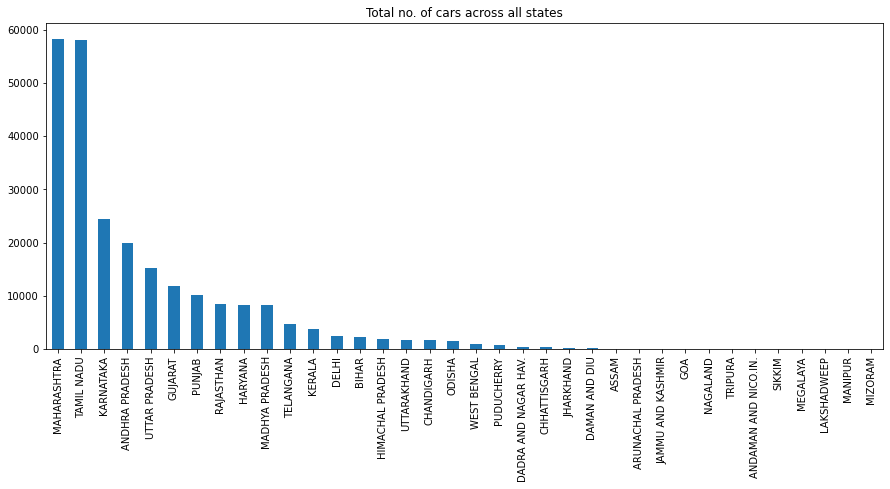

In [16]:
#For car we have mutiple entries in Invoice remove duplicate records 
df_car_regn = df_final[['REGNNO' , 'STATE','CITY','CUSTOMERNO','MAKE']].copy()
df_car_regn.sort_values(by=['REGNNO'],inplace=True)
df_car_regn.drop_duplicates(subset=['REGNNO'], keep='first',inplace=True)
#1.1Which areas have most cars?
total_cars = df_car_regn['STATE'].value_counts() 
plot = total_cars.plot(kind='bar', title = "Total no. of cars across all states", figsize=(15,6))
plt.xticks(fontsize =10 , rotation=90);

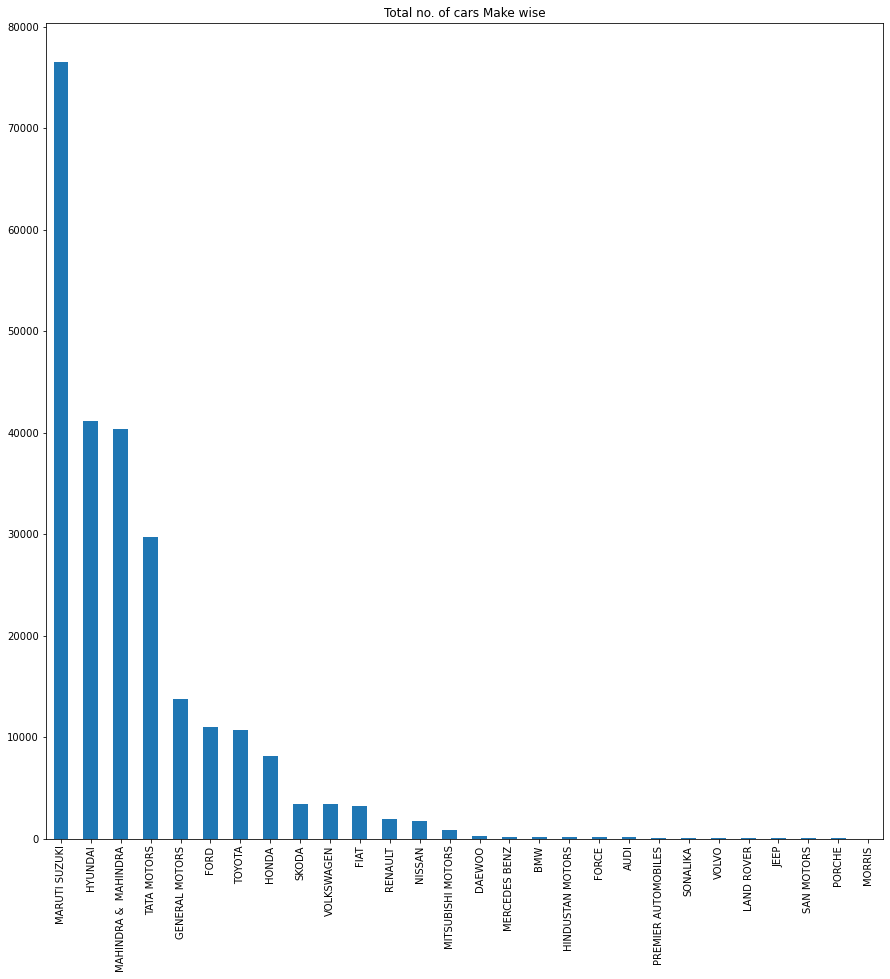

In [17]:
#1.2Which make/car is more popular?
total_cars = df_car_regn['MAKE'].value_counts() 
plot = total_cars.plot(kind='bar', title = "Total no. of cars Make wise", figsize=(15,15))
plt.xticks(fontsize =10 , rotation=90);

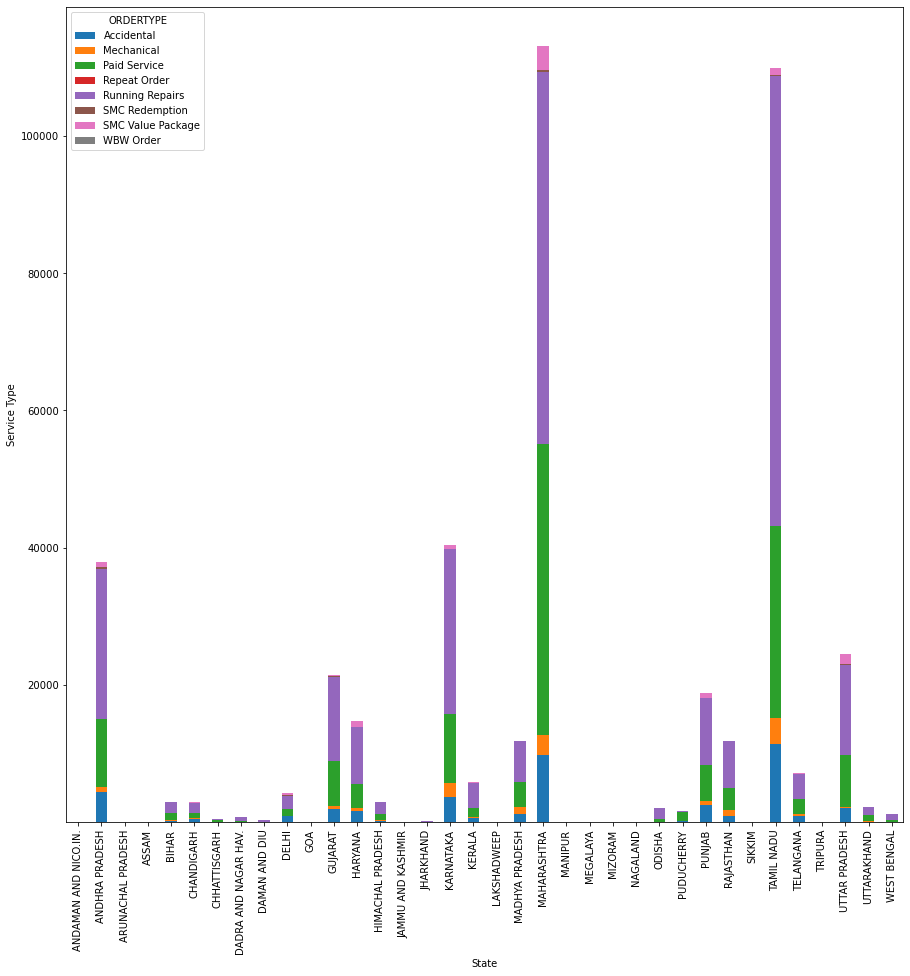

In [18]:
#1.4Which type of service is popular in a certain area?
res = df_final.groupby(['STATE','ORDERTYPE']).size().unstack()
#print(res)
#Plot stacked bar chart
res.plot(kind='bar', stacked=True, figsize=(15,15))
plt.xlabel('State')
plt.ylabel('Service Type')
#Display plot
plt.show()

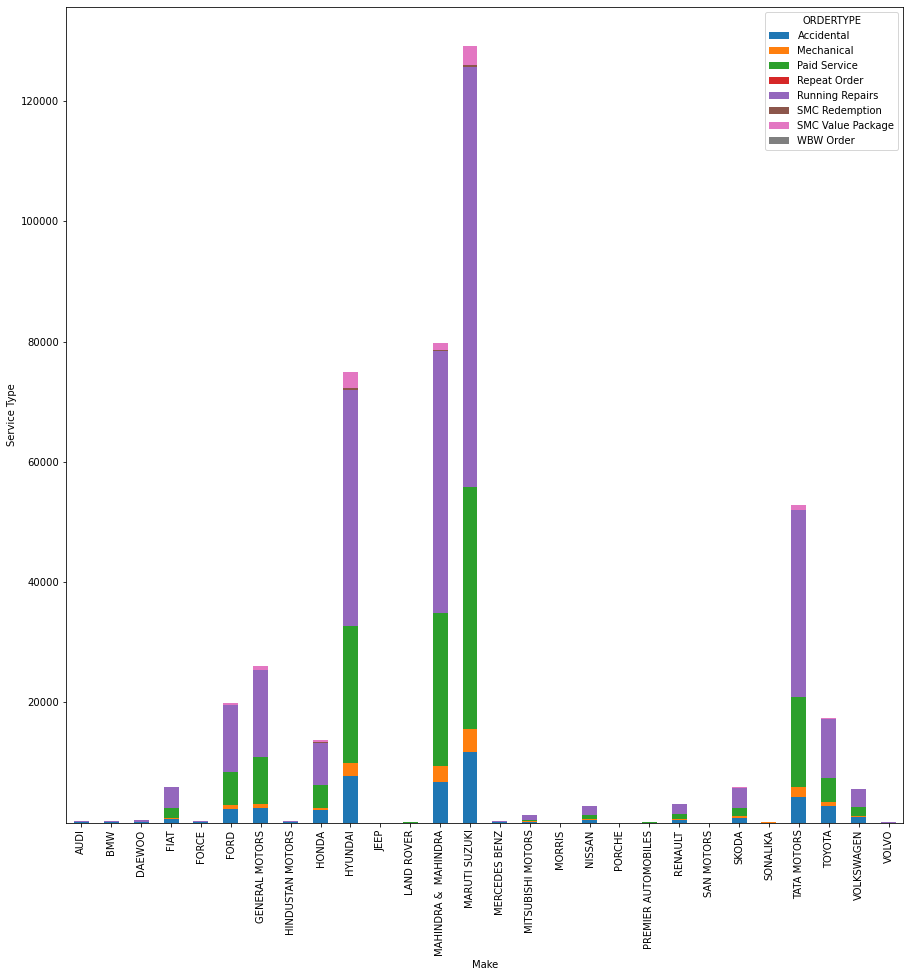

In [19]:
#1.3What is service structure for particular make/car?
res = df_final.groupby(['MAKE','ORDERTYPE']).size().unstack()
#print(res)
# Plot stacked bar chart
res.plot(kind='bar', stacked=True, figsize=(15,15))
plt.ylabel('Service Type')
plt.xlabel('Make')
# Display plot
plt.show()

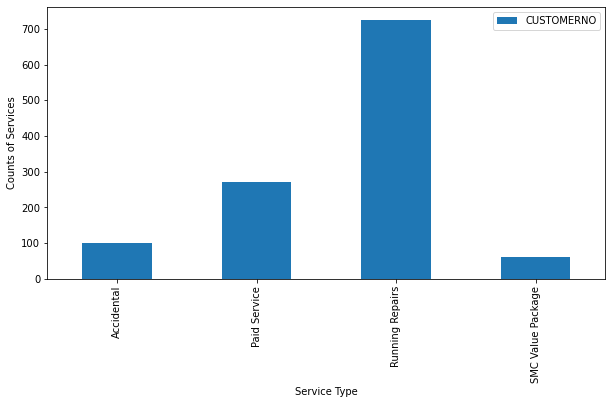

In [20]:
res = df_invoice.groupby(['ORDERTYPE']).count()['CUSTOMERNO'].to_frame()
# Plot stacked bar chart
res.plot(kind='bar', stacked=True, figsize=(10,5))
plt.xlabel('Service Type')
plt.ylabel('Counts of Services')
# Display plot
plt.show()

In [21]:
df_final.describe()

,UNNAMED0,LABOURTOTAL,MISCTOTAL,OSLTOTAL,PARTSTOTAL,TOTALAMTWTDTAX,SERVICETIME
count,440138.000000,440138.000000,440138.000000,440138.000000,440138.000000,440138.000000,1157.000000
mean,577972.707642,1514.119153,155.091664,521.322204,2725.444563,4915.977584,2.716508
std,312076.139859,3917.601596,1513.937043,2620.958471,8328.067572,11609.517084,7.115642
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000
25%,560566.250000,199.400000,0.000000,0.000000,0.000000,496.602500,0.000000
50%,685555.500000,648.960000,0.000000,0.000000,607.425000,1942.345000,0.000000
75%,806396.750000,1424.970000,50.000000,0.000000,2636.280000,4998.650000,3.000000
max,984740.000000,323000.000000,350000.000000,119444.190000,598003.480000,648203.490000,118.000000


<AxesSubplot:xlabel='ORDERTYPE', ylabel='SERVICETIME'>

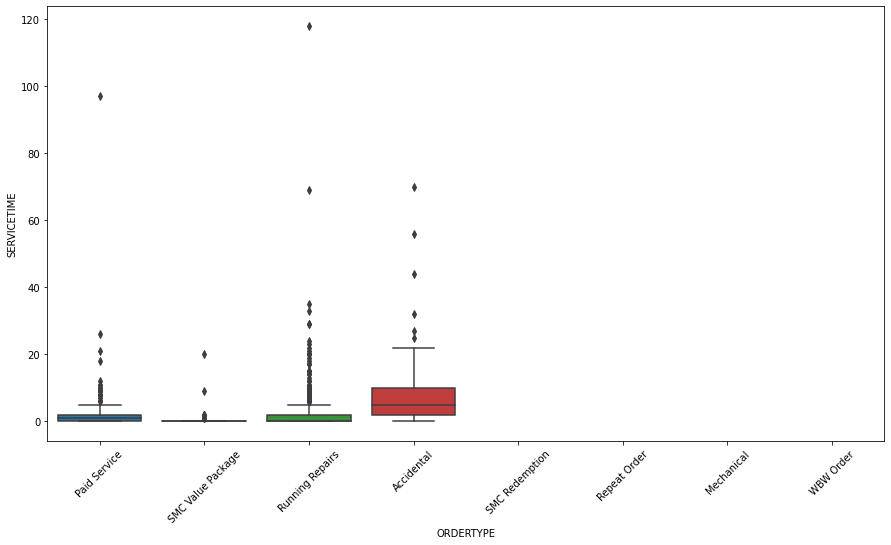

In [22]:
#Check outlier for service time 
import seaborn as sns
plt.figure(figsize=(15,8))
plt.xticks(rotation = 45)
sns.boxplot('ORDERTYPE', 'SERVICETIME', data=df_final)

<AxesSubplot:xlabel='ORDERTYPE', ylabel='SERVICETIME'>

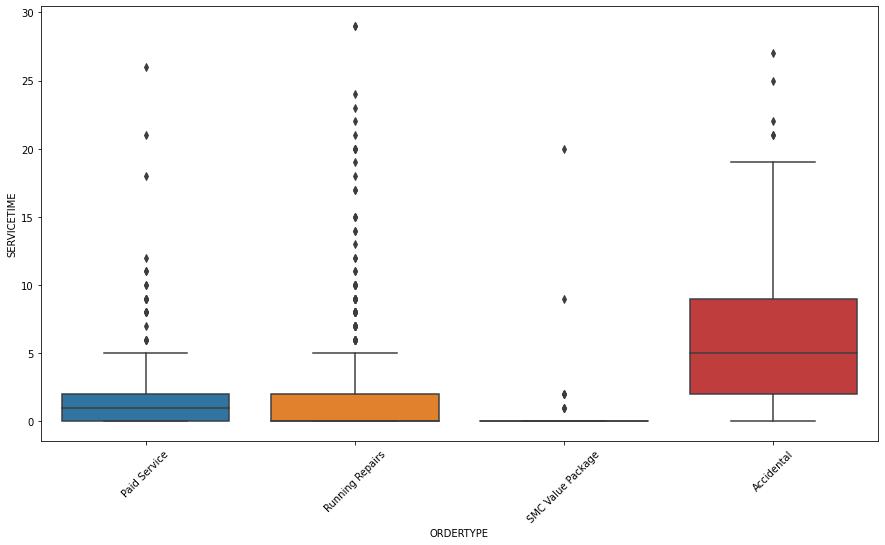

In [23]:
#Delete service took more than 30 days
res = df_final[df_final['SERVICETIME'] <= 30]
plt.figure(figsize=(15,8))
plt.xticks(rotation = 45)
sns.boxplot('ORDERTYPE', 'SERVICETIME', data=res)

In [24]:
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
%matplotlib inline

In [25]:
df_final.columns

Index(['UNNAMED0', 'AREALOCALITY', 'CUSTTYPE', 'CUSTOMERNO', 'GATEPASSTIME',
       'INVOICEDATE', 'INVOICENO', 'INVOICETIME', 'JOBCARDNO', 'JOBCARDDATE',
       'JOBCARDTIME', 'KMSREADING', 'LABOURTOTAL', 'MAKE', 'MISCTOTAL',
       'MODEL', 'OSLTOTAL', 'ORDERTYPE', 'PARTSTOTAL', 'PINCODE', 'PLANT',
       'PLANTNAME1', 'PRINTSTATUS', 'RECOVRBLEXP', 'REGNNO', 'TOTALAMTWTDTAX',
       'USERID', 'STATE', 'CITY', 'JOBCARDDATETIME', 'INVOICEDATETIME',
       'SERVICETIME'],
      dtype='object')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


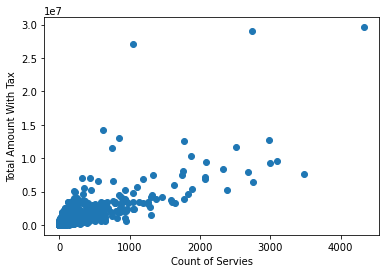

In [26]:
#Get the revnue based on State/City create dataframe on sum of labour count number of invoices
df_sum = pd.DataFrame(df_final.groupby(['STATE','CITY','MAKE','CUSTTYPE','ORDERTYPE']) \
                      ['LABOURTOTAL','MISCTOTAL','OSLTOTAL','PARTSTOTAL','TOTALAMTWTDTAX'].sum().reset_index())
df_count = pd.DataFrame(df_final.groupby(['STATE','CITY','MAKE','CUSTTYPE','ORDERTYPE'])['TOTALAMTWTDTAX'].count().reset_index())
df_count.rename(columns={"TOTALAMTWTDTAX": "COUNT"},inplace=True)
df = df_sum.merge(df_count, left_on=['STATE','CITY','MAKE','CUSTTYPE','ORDERTYPE'], \
                  right_on=['STATE','CITY','MAKE','CUSTTYPE','ORDERTYPE'])

plt.scatter(x=df['COUNT'],y=df['TOTALAMTWTDTAX'])
plt.xlabel('Count of Servies')
plt.ylabel('Total Amount With Tax')
plt.show()

In [27]:
df.to_csv('Spending_analysis.csv')